# Diffusion model

Implementation is a mix of 
- [The Annotated Diffusion Model tutorial](https://huggingface.co/blog/annotated-diffusion) by Niels Rogge & Kashif Rasul
- the codebase for [Diffusion Models Beat GANS on Image Synthesis](https://github.com/openai/guided-diffusion)
- the codebase for [ GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models](https://github.com/openai/glide-text2im)

# Imports

In [ ]:
#@title
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from functools import partial
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F  
from torch.utils.data import random_split
from skimage.metrics import structural_similarity as ssim
from skimage.draw import random_shapes
import skimage
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, einsum
import math
!pip install -q -U einops
from einops import rearrange

# Data

In [ ]:
#@title
from torchvision import transforms
from torch.utils.data import DataLoader

# load dataset from the hub
transform = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: ((t * 2) - 1)*0.8)
])
dataset = datasets.MNIST(root='data', download=True, transform=transform)
dataset, validation_data = random_split(dataset, [50000, 10000])
image_size = 28
channels = 1
batch_size = 100

# create dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=2)

batch = next(iter(dataloader))
print(batch[0].shape)
print(batch[1].shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([100, 1, 28, 28])
torch.Size([100])


# Utils

In [ ]:
#@title
def exists(x):
    return x is not None

from inspect import isfunction
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

"""The SinusoidalPositionEmbeddings module takes a tensor of shape (batch_size, 1) as input (i.e. the noise levels of several noisy images in a batch), 
and turns this into a tensor of shape (batch_size, dim), with dim being the dimensionality of the position embeddings. This is then added to each residual block"""
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Block of conv, norm, activation function
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )
        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h
        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

# U-Net model

In [ ]:
#@title
class Unet(nn.Module):
    def __init__(self,dim,init_dim=None,out_dim=None,dim_mults=(1, 2, 4, 8),channels=3,with_time_emb=True,resnet_block_groups=8, num_classes=None):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.num_classes = num_classes
        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        # down sampling layers
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        # mid layers
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        # up sampling layers
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        # output layers
        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time, y=None):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            t = t + self.label_emb(y)

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

model = Unet(
    dim=32,
    channels=1,
    dim_mults=(1, 2, 4,),
    num_classes = None
)
model.to(device)

Unet(
  (init_conv): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(20, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Re

# Variance schedule + all related values

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

alphas_cumprod_next = F.pad(alphas_cumprod[1:], (0, 1), value=0)

# Forward sampling according to nice property

In [ ]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# Loss function

The loss function takes the original image, noise it with the forward process function and then compute the predicted noise using the model. It ouputs the loss between the predicted noise and the real noise 

In [ ]:
def p_losses(denoise_model, x_start, t, label, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, y=label)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Training (unconditional model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      images, _ = batch 
      images = images.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, images, t, loss_type="huber", label=None)
      loss.backward()
      optimizer.step()
print("Loss:", loss.item())

100%|██████████| 20/20 [17:14<00:00, 51.75s/it]

Loss: 0.02039657160639763


# DDPM sampling

Sampling functions for DDPM

In [ ]:
# Sampling functions DDPM
@torch.no_grad()
def p_sample(model, x, t, t_index, label=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, y=label) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape, label=None):
    #device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, label=label)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3, label=None):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), label=label)

Test sampling

sampling loop time step: 100%|██████████| 200/200 [00:03<00:00, 53.13it/s]


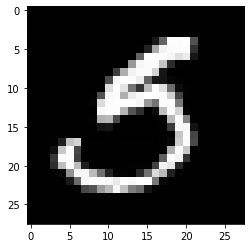

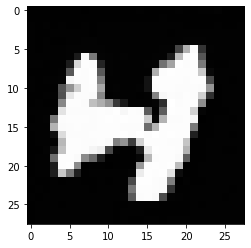

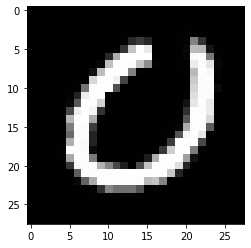

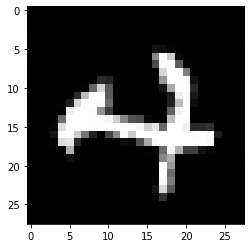

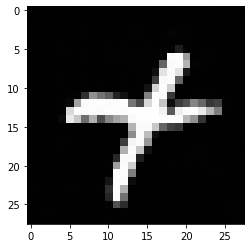

In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
for i in range(5):
  plt.figure()
  plt.imshow(samples[-1][i].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

<Figure size 432x288 with 0 Axes>

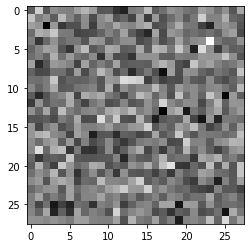

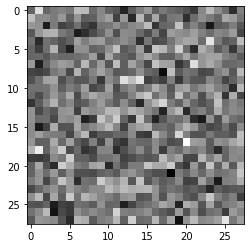

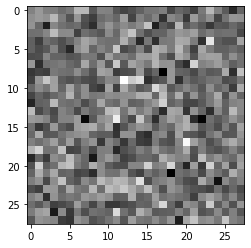

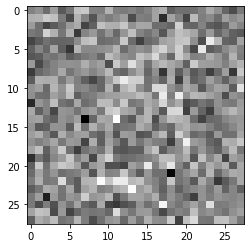

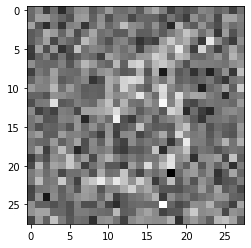

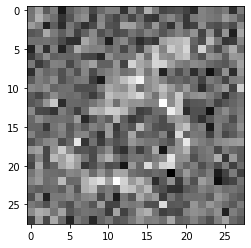

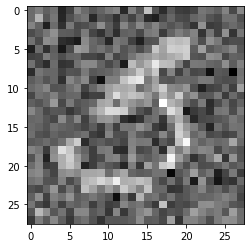

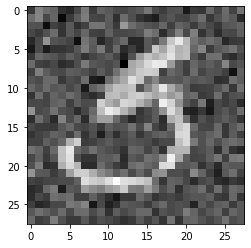

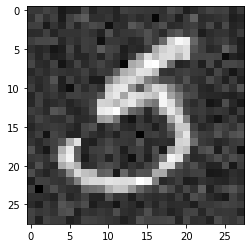

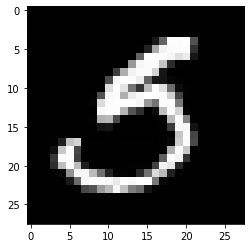

In [ ]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []
random_index =0
for i in range(timesteps):
  if (i+1)%20==0:
    plt.figure()
    plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray", animated=True)

Samples from the same original latent

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 68.56it/s]


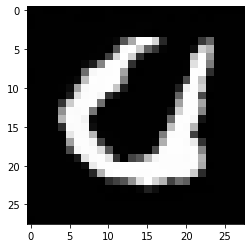

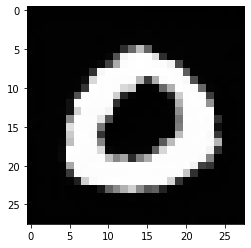

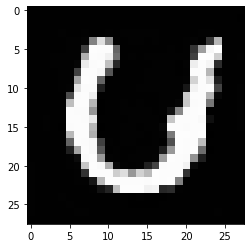

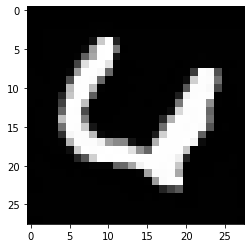

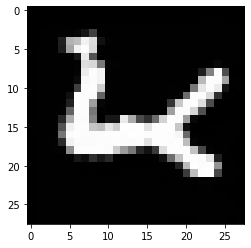

In [ ]:
@torch.no_grad()
def p_sample_loop_same(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn((shape[1],shape[2],shape[3]), device=device).repeat((b,1,1,1)).contiguous()

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
    return img

@torch.no_grad()
def sample_same(model, image_size, batch_size=16, channels=3):
    return p_sample_loop_same(model, shape=(batch_size, channels, image_size, image_size))

# sample 64 images
samples = sample_same(model, image_size=image_size, batch_size=10, channels=channels)

for i in range(5):
  random_index = i
  plt.figure()
  plt.imshow(samples[random_index].reshape(image_size, image_size, channels).detach().cpu().squeeze(), cmap="gray")

# DDIM

Sampling functions for DDIM

In [ ]:
@torch.no_grad()
def ddim_sample(model, x, t, t_index, eta, label=None):
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x.shape)

    if t_index == 0:
        z_theta = model(x, t, y=label)
        x0 = (x - z_theta * sqrt_one_minus_alphas_cumprod_t) / sqrt_alphas_cumprod_t
        return  x0
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        alphas_cumprod_prev_t = extract(alphas_cumprod_prev, t, x.shape)
        z_theta = model(x, t, y=label)
        x0 = (x - z_theta * sqrt_one_minus_alphas_cumprod_t) / sqrt_alphas_cumprod_t
        c1 = eta * torch.sqrt(posterior_variance_t)
        c2 = ((1 - alphas_cumprod_prev_t) - c1 ** 2).sqrt()
        model_mean = alphas_cumprod_prev_t.sqrt() * x0  + c2 * z_theta
        noise = torch.randn_like(x)
        return model_mean + c1*noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def ddim_loop(model, shape,seeded,eta,x_start, label=None):
    #device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    if seeded:
      img = torch.randn((shape[1],shape[2],shape[3]), device=device).repeat(((b,1,1,1)))
    elif x_start != None:
      img = ddim_inversion(model, x_start)
    else:
      img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = ddim_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, eta, label=label)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def ddim_generation(model, image_size, batch_size=16, channels=3, seeded=False, eta=0, x_start=None, label=None):
    return ddim_loop(model, shape=(batch_size, channels, image_size, image_size),seeded=seeded, eta=eta,x_start=x_start, label=label)

DDIM inversion

In [ ]:
@torch.no_grad()
def ddim_inversion_fn(model, x, t, t_index):
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x.shape)

    alphas_cumprod_next_t = extract(alphas_cumprod_next, t, x.shape)
    z_theta = model(x, t)
    x0 = (x - z_theta * sqrt_one_minus_alphas_cumprod_t) / sqrt_alphas_cumprod_t
    c2 = ((1 - alphas_cumprod_next_t)).sqrt()
    x_next = alphas_cumprod_next_t.sqrt() * x0  + c2 * z_theta
    return x_next 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def ddim_inversion(model, x_start):
    #device = next(model.parameters()).device
    img = x_start
    for i in tqdm((range(0, timesteps-1)), desc='inversion loop time step', total=timesteps):
        img = ddim_inversion_fn(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), i)
    return img

Sampling from DDIM

sampling loop time step: 100%|██████████| 200/200 [00:03<00:00, 53.65it/s]


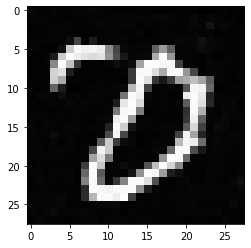

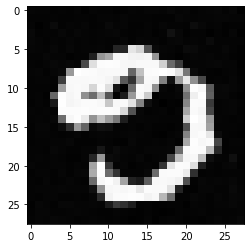

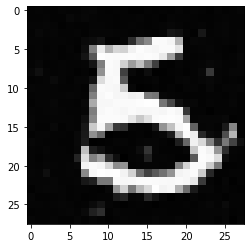

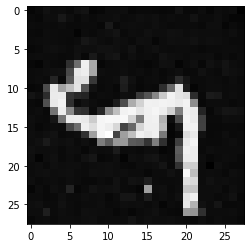

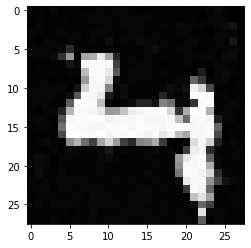

In [ ]:
# sample 64 images
samples = ddim_generation(model, image_size=image_size, batch_size=64, channels=channels,eta=0)

# show a random one
for i in range(5):
  plt.figure()
  plt.imshow(samples[-1][i].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

Sampling from the same original latent

sampling loop time step: 100%|██████████| 200/200 [00:04<00:00, 43.27it/s]


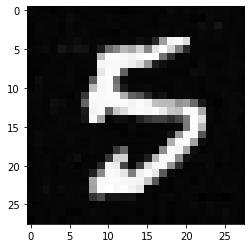

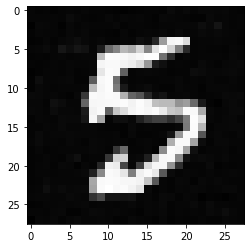

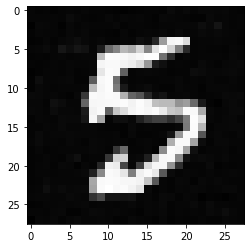

In [ ]:
# sample 64 images
samples = ddim_generation(model, image_size=image_size, batch_size=64, channels=channels,eta=0,seeded=True)

# show a random one
for i in range(3):
  random_index = i
  plt.figure()
  plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

DDIM inversion and reconstruction

sampling loop time step: 100%|██████████| 200/200 [00:05<00:00, 38.14it/s]


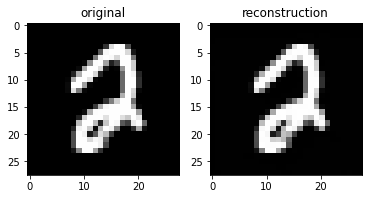

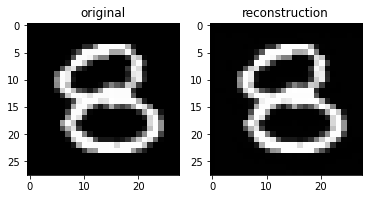

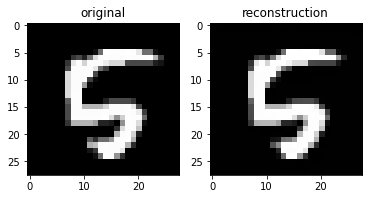

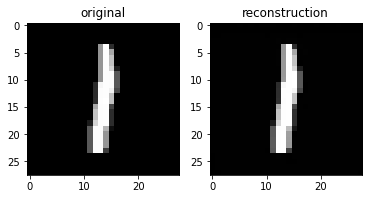

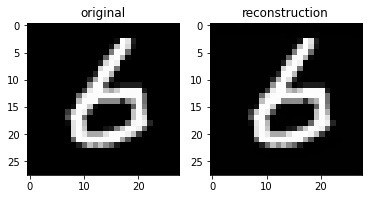

In [ ]:
# sample 64 images
samples = ddim_generation(model, image_size=image_size, batch_size=batch_size, channels=channels,eta=0,x_start=images)

for i in range(0,5):
  random_index = i
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(images[random_index].detach().cpu().squeeze(),cmap='gray')
  axarr[0].set_title("original")
  axarr[1].imshow(samples[-1][random_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")
  axarr[1].set_title("reconstruction")

# Training (conditional model)

Train a conditional model with 20% dropped labels

In [ ]:
model = Unet(
    dim=32,
    channels=1,
    dim_mults=(1, 2, 4,),
    num_classes = 11
)
model.to(device);

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      images, labels = batch 
      images = images.to(device)
      labels = labels+1
      p = torch.tensor(np.random.uniform(low=0.0, high=1.0,size=batch_size) > 0.2).to(labels)
      labels = p*labels
      labels = labels.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, images, t, labels, loss_type="huber")
      loss.backward()
      optimizer.step()
print("Loss:", loss.item())

100%|██████████| 20/20 [17:02<00:00, 51.12s/it]

Loss: 0.019680418074131012


# Conditional Generation

tensor([ 8,  5,  6,  8,  4, 10,  6,  5,  7,  3,  3,  5,  4,  1,  6,  7,  3,  8,
         4,  3,  3,  7,  4,  7,  3,  7, 10,  2,  5,  9,  3,  7,  3,  3,  4,  5,
         8,  5,  6,  1,  2,  2,  1,  5,  2,  1,  4,  1,  2,  1,  5,  3,  3,  5,
         3, 10,  2,  2,  5,  1,  8,  6,  9,  8,  8,  8, 10,  3,  2,  3,  4,  3,
         1,  3,  6,  1,  3,  2,  8,  1,  9,  4,  2,  1,  9,  1,  8,  3, 10,  1,
         1,  4,  2,  4, 10,  9,  6,  9,  8,  1])


sampling loop time step: 100%|██████████| 200/200 [00:03<00:00, 53.29it/s]


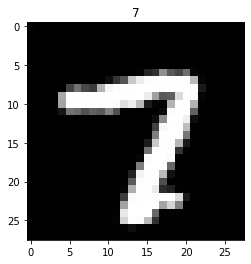

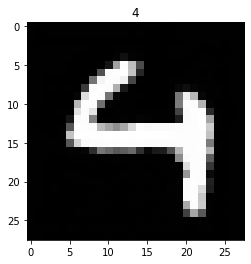

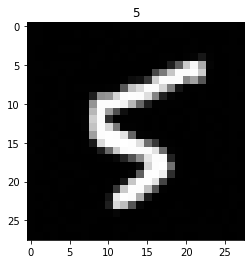

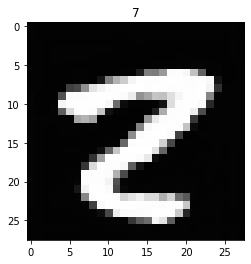

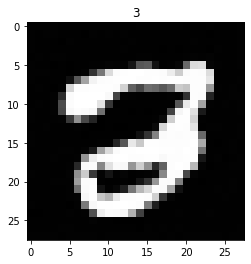

In [ ]:
# sample 64 images
images, labels = batch 
labels = labels+1
print(labels)
samples = sample(model, image_size=image_size, batch_size=64, channels=channels, label=labels[:64].to(device))
#samples = ddim_generation(model, image_size=image_size, batch_size=64, channels=channels, seeded=False, eta=0, x_start=None, label=labels[:64])

# show a random one
for i in range(5):
 random_index =i
 plt.figure()
 plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")
 plt.title(labels[random_index].item()-1);

# Conditional Generation with classifier free guidance

tensor([ 4,  1, 10,  3,  1,  3,  4,  1,  9,  8,  4,  2,  9,  7,  3,  3,  8,  6,
         7,  8,  3,  8,  5,  3,  2,  6, 10,  1,  6,  3,  3, 10,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.int32)


sampling loop time step: 100%|██████████| 200/200 [00:03<00:00, 51.60it/s]


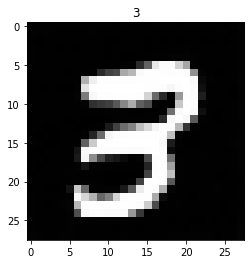

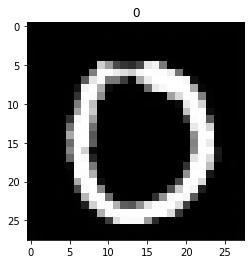

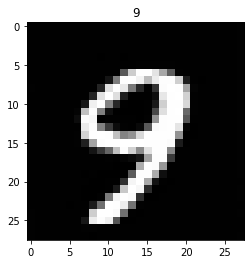

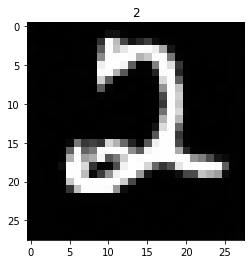

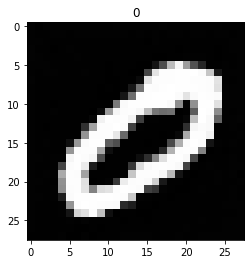

In [ ]:
guidance_scale = 3.0

def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = torch.cat([half, half], dim=0)
    eps = model(combined, ts, **kwargs)#model_out = model(combined, ts, **kwargs)
    #eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = torch.cat([half_eps, half_eps], dim=0)
    return eps#torch.cat([eps, rest], dim=1)

a = np.random.randint(1,11,size=32)
b = np.zeros(32)
labels = torch.tensor(np.concatenate((a,b)))
print(labels.int())
samples = sample(model_fn, image_size=image_size, batch_size=64, channels=channels, label=labels.int().to(device))

# show a random one
for i in range(5):
 random_index =i
 plt.figure()
 plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")
 plt.title(labels.int()[random_index].item()-1);